In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First few rows of dataset:
         Income  Age  Dependents     Occupation City_Tier          Rent  \
0   44637.24964   49           0  Self_Employed    Tier_1  13391.174890   
1   26858.59659   34           2        Retired    Tier_2   5371.719318   
2   50367.60508   35           1        Student    Tier_3   7555.140763   
3  101455.60020   21           0  Self_Employed    Tier_3  15218.340040   
4   24875.28355   52           4   Professional    Tier_2   4975.056710   

   Loan_Repayment    Insurance     Groceries    Transport  ...  \
0        0.000000  2206.490129   6658.768341  2636.970696  ...   
1        0.000000   869.522617   2818.444460  1543.018778  ...   
2     4612.103386  2201.800050   6313.222081  3221.396403  ...   
3     6809.441427  4889.418087  14690.149360  7106.130005  ...   
4     3112.609398   635.907170   3034.329665  1276.155163  ...   

   Desired_Savings  Disposable_Income  Potential_Savings_Groceries  \
0      6200.537192       11265.627710                  

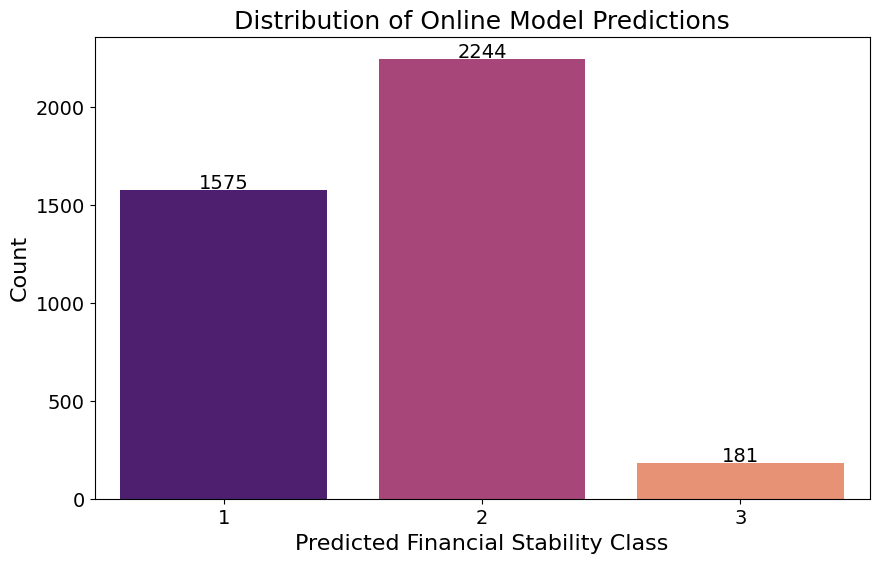

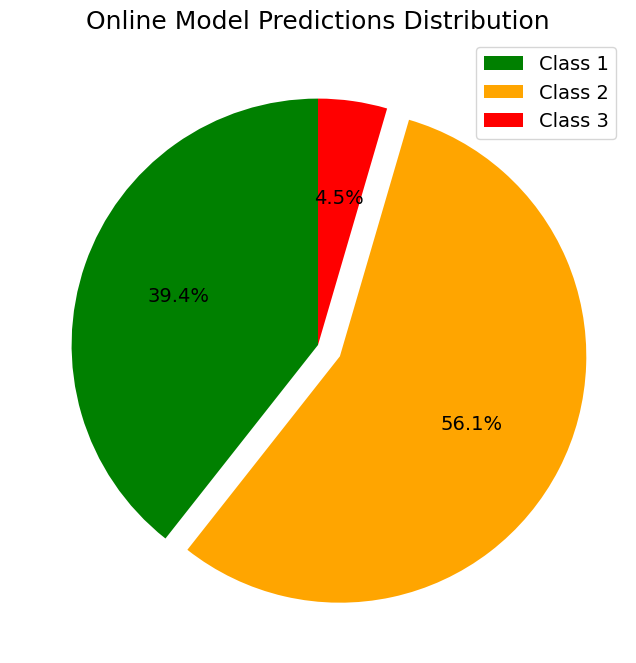

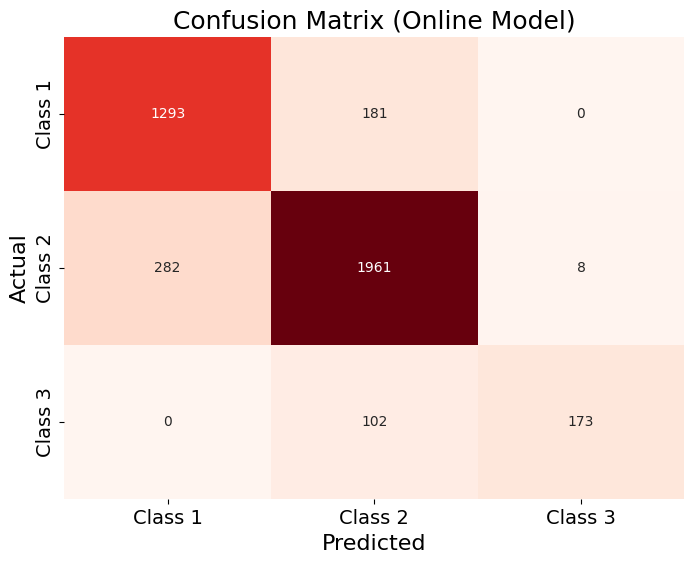

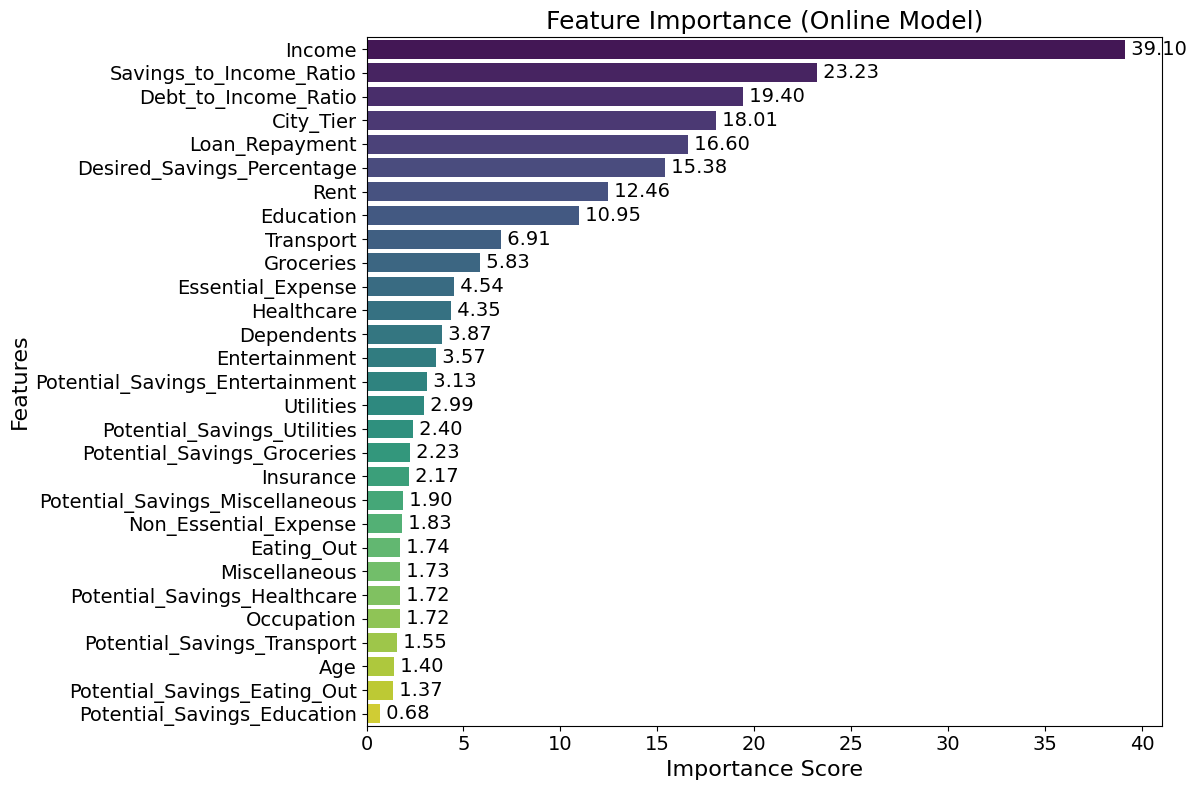

In [2]:
# Install necessary library
!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier  # (Not used for training, but for comparisons if needed)
from sklearn.linear_model import SGDClassifier  # Online learning model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
csv_path = "/kaggle/input/financial-stability-online/data1.csv"  # Update with your actual path
df = pd.read_csv(csv_path)

# Display first few rows and check for missing values
print("First few rows of dataset:")
print(df.head())
print("\nMissing values in each column:")
print(df.isnull().sum())

# Drop irrelevant columns if they exist
drop_cols = ['column1', 'column2']  # Replace with actual unnecessary column names if needed
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# If 'Financial Stability' target column is not present, create it
if 'Financial Stability' not in df.columns:
    # Create new financial ratios
    df["Debt_to_Income_Ratio"] = df["Loan_Repayment"] / df["Income"]
    df["Savings_to_Income_Ratio"] = df["Desired_Savings"] / df["Income"]
    df["Essential_Expense"] = df["Groceries"] + df["Transport"] + df["Utilities"] + df["Healthcare"]
    df["Non_Essential_Expense"] = df["Eating_Out"] + df["Entertainment"] + df["Miscellaneous"]

    # Define Financial Stability Classes based on criteria:
    # 1: Financially Stable, 2: Moderately Stable, 3: Financially Unstable
    def classify_stability(row):
        if row["Disposable_Income"] > 0.3 * row["Income"] and row["Debt_to_Income_Ratio"] < 0.2:
            return 1  # Financially Stable
        elif row["Disposable_Income"] > 0.1 * row["Income"] and row["Debt_to_Income_Ratio"] < 0.4:
            return 2  # Moderately Stable
        else:
            return 3  # Financially Unstable

    df["Financial Stability"] = df.apply(classify_stability, axis=1)

# Define Features (X) and Target (y)
X = df.drop(columns=["Financial Stability", "Disposable_Income", "Desired_Savings"])
y = df["Financial Stability"]

# Encode categorical variables
for col in ['Occupation', 'City_Tier']:
    if col in X.columns:
        X[col] = LabelEncoder().fit_transform(X[col])

# Split Data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize Data for Models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Online Learning Model: SGDClassifier using partial_fit
online_model = SGDClassifier(loss='log_loss', random_state=42)
classes = np.unique(y_train)
batch_size = 100

# Incremental training: update the model in batches
for i in range(0, X_train.shape[0], batch_size):
    online_model.partial_fit(X_train[i:i+batch_size], y_train.iloc[i:i+batch_size], classes=classes)

# Predictions and evaluation for the online model
y_pred_online = online_model.predict(X_test)
online_accuracy = accuracy_score(y_test, y_pred_online)
print("Online Model (SGDClassifier) Accuracy: {:.0f}%".format(online_accuracy * 100))
print("\nOnline Model (SGDClassifier) Classification Report:")
print(classification_report(y_test, y_pred_online))

### Enhanced Visualizations for Online Model

# 1. Bar Chart: Distribution of Online Model Predictions
plt.figure(figsize=(10,6))
ax = sns.countplot(x=y_pred_online, palette="magma")
plt.title("Distribution of Online Model Predictions", fontsize=18)
plt.xlabel("Predicted Financial Stability Class", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=14, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.show()

# 2. Pie Chart: Percentage Distribution of Online Model Predictions
plt.figure(figsize=(8,8))
online_counts = pd.Series(y_pred_online).value_counts().sort_index()
online_labels = [f'Class {i}' for i in online_counts.index]
explode = [0.1 if count == max(online_counts) else 0 for count in online_counts]
plt.pie(online_counts, autopct="%1.1f%%", startangle=90, explode=explode,
        colors=["green", "orange", "red"], textprops={'fontsize':14})
plt.title("Online Model Predictions Distribution", fontsize=18)
plt.legend(labels=online_labels, loc="best", fontsize=14)
plt.show()

# 3. Confusion Matrix for Online Model
unique_classes = sorted(np.unique(np.concatenate((y_test, y_pred_online))))
cm_online = confusion_matrix(y_test, y_pred_online, labels=unique_classes)
cm_labels = [f'Class {i}' for i in unique_classes]

plt.figure(figsize=(8,6))
sns.heatmap(cm_online, annot=True, fmt="d", cmap="Reds",
            xticklabels=cm_labels, yticklabels=cm_labels, cbar=False)
plt.title("Confusion Matrix (Online Model)", fontsize=18)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# 4. Feature Importance for Online Model
# For SGDClassifier, we use the absolute average of the coefficients as a proxy for feature importance.
feature_names = X.columns
importance = np.abs(online_model.coef_).mean(axis=0)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance (Online Model)", fontsize=18)
plt.xlabel("Importance Score", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for index, value in enumerate(importance_df["Importance"]):
    plt.text(value, index, f" {value:.2f}", va="center", fontsize=14)
plt.tight_layout()
plt.show()